# Spam

In [76]:
import pandas as pd
import re
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
import numpy as np
from sklearn.model_selection import GridSearchCV
from pickle import dump

In [77]:
data = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv")
data.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


In [78]:
# Convirtiendo True/False → 1/0
data["is_spam"] = data["is_spam"].astype(int)
data


,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,1
1,https://www.hvper.com/,1
2,https://briefingday.com/m/v4n3i4f3,1
3,https://briefingday.com/n/20200618/m#commentform,0
4,https://briefingday.com/fan,1
...,...,...
2994,https://www.smartcitiesworld.net/news/news/dee...,0
2995,https://www.youtube.com/watch,1
2996,https://techcrunch.com/2019/07/04/an-optimisti...,0
2997,https://www.technologyreview.com/2019/12/20/13...,0


In [79]:
# Eliminando duplicados
data = data.drop_duplicates().reset_index(drop=True)
data


,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,1
1,https://www.hvper.com/,1
2,https://briefingday.com/m/v4n3i4f3,1
3,https://briefingday.com/n/20200618/m#commentform,0
4,https://briefingday.com/fan,1
...,...,...
2364,https://www.theverge.com/2020/6/29/21306889/di...,0
2365,https://www.smartcitiesworld.net/news/news/dee...,0
2366,https://techcrunch.com/2019/07/04/an-optimisti...,0
2367,https://www.technologyreview.com/2019/12/20/13...,0


In [80]:
# Descargas de NLTK
download("wordnet")
download("stopwords")

stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [81]:
def preprocess(url):

    # Convertir a minúscula
    url = url.lower()

    # Sustituir caracteres que no sean letras por espacio
    url = re.sub(r"[^a-z]", " ", url)

    # Quitar espacios múltiples
    url = re.sub(r"\s+", " ", url)

    # Tokenizar
    tokens = url.split()

    # Lematizar
    tokens = [lemmatizer.lemmatize(tok) for tok in tokens]

    # Eliminar stopwords
    tokens = [tok for tok in tokens if tok not in stop_words]

    # Filtrar tokens muy cortos
    tokens = [tok for tok in tokens if len(tok) > 2]

    return " ".join(tokens)


data["url_clean"] = data["url"].apply(preprocess)
data

,url,is_spam,url_clean
0,https://briefingday.us8.list-manage.com/unsubs...,1,http briefingday list manage com unsubscribe
1,https://www.hvper.com/,1,http www hvper com
2,https://briefingday.com/m/v4n3i4f3,1,http briefingday com
3,https://briefingday.com/n/20200618/m#commentform,0,http briefingday com commentform
4,https://briefingday.com/fan,1,http briefingday com fan
...,...,...,...
2364,https://www.theverge.com/2020/6/29/21306889/di...,0,http www theverge com disney deepfake face swa...
2365,https://www.smartcitiesworld.net/news/news/dee...,0,http www smartcitiesworld net news news deepfa...
2366,https://techcrunch.com/2019/07/04/an-optimisti...,0,http techcrunch com optimistic view deepfakes
2367,https://www.technologyreview.com/2019/12/20/13...,0,http www technologyreview com startup claim de...


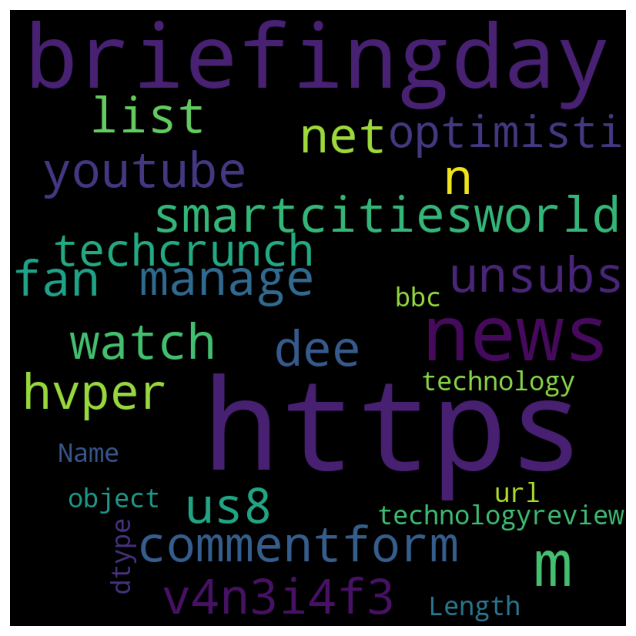

In [82]:
wordcloud = WordCloud(width = 800, height = 800, background_color = "black", max_words = 1000, min_font_size = 20, random_state = 42)\
    .generate(str(total_data["url"]))

fig = plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [83]:
# Vectorización con TF-IDF


vectorizer = TfidfVectorizer(max_features=5000, max_df=0.8, min_df=5)
X = vectorizer.fit_transform(data["url_clean"])
y = data["is_spam"]


In [84]:
# Train / Test split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [85]:
#  Entrenar modelo base SVC

model = SVC(kernel="linear", random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
f"Accuracy modelo base: {accuracy_score(y_test, y_pred)}"

'Accuracy modelo base: 0.9514767932489452'

In [86]:
# optimizacion
param_grid = {"C": [0.01, 0.1, 1, 10, 100],
              "kernel": ["linear", "poly", "rbf", "sigmoid"],
              "gamma": ["scale", "auto"],
              "degree": [1, 2, 3]}

grid = GridSearchCV(SVC(random_state=42),
                    param_grid,
                    scoring="accuracy",
                    cv=5,
                    n_jobs=-1)

grid.fit(X_train, y_train)


,estimator,SVC(random_state=42)
,param_grid,"{'C': [0.01, 0.1, ...], 'degree': [1, 2, ...], 'gamma': ['scale', 'auto'], 'kernel': ['linear', 'poly', ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,10


In [ ]:
# optimizado

best_model = grid.best_estimator_
accuracy_opt = accuracy_score(y_test, best_model.predict(X_test))

accuracy_opt

0.9556962025316456

In [88]:
# guardado

dump(best_model, open("svm_url_model.pkl", "wb"))
dump(vectorizer, open("tfidf_url_vectorizer.pkl", "wb"))